In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import dill
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv("../data/asteroids_processed.csv")

In [3]:
y = data['hazardous']
X = data.drop('hazardous', axis=1)

In [5]:
y.value_counts()

hazardous
0    74983
1     6347
Name: count, dtype: int64

<font size = 4>
Так как в столбце целевого признака имеется всего 2 класса (астероид опасен или не опасен), то задача относится к типу задач бинарной классификации
</font>

In [4]:
oversample = SMOTE()
transformed_X, transformed_y = oversample.fit_resample(X, y)

In [5]:
transformed_y.value_counts()

hazardous
0    74983
1    74983
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(transformed_X, transformed_y, test_size=0.2, random_state=42, stratify=transformed_y)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((119972, 5), (119972,), (29994, 5), (29994,))

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
import pickle
with open('../models/scaler_knn.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
def print_metrics(y_test, y_pred):
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('Precision:', round(precision_score(y_test, y_pred), 4))
    print('Recall:', round(recall_score(y_test, y_pred), 4))
    print('F1-score:', round(f1_score(y_test, y_pred), 2))
    print('ROC AUC score:', round(roc_auc_score(y_test, y_pred), 4))
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

def kfold_metrics(results):
    print('Accuracy:', round(np.mean(results['test_accuracy']), 4))
    print('Precision:', round(np.mean(results['test_precision']), 4))
    print('Recall:', round(np.mean(results['test_recall']), 4))
    print('F1-score:', round(np.mean(results['test_f1']), 2))
    print('ROC AUC score:', round(np.mean(results['test_roc_auc']), 4))

def plot_roc_curve(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

<font size = 6>
    <b>KNN</b>
</font>

In [15]:
knn = KNeighborsClassifier(n_neighbors = 9, metric='manhattan')
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_metrics(y_test, y_pred)

Accuracy: 0.9212
Precision: 0.8801
Recall: 0.9753
F1-score: 0.93
ROC AUC score: 0.9212
Confusion matrix: 
 [[13005  1992]
 [  371 14626]]


In [93]:
knn = KNeighborsClassifier(n_neighbors = 9, metric='cosine')
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_metrics(y_test, y_pred)

Accuracy: 0.9148
Precision: 0.8698
Recall: 0.9757
F1-score: 0.92
ROC AUC score: 0.9148
Confusion matrix: 
 [[12806  2191]
 [  365 14632]]


Accuracy: 0.9172
Precision: 0.8742
Recall: 0.9745
F1-score: 0.92
ROC AUC score: 0.9172
Confusion matrix: 
 [[12894  2103]
 [  382 14615]]


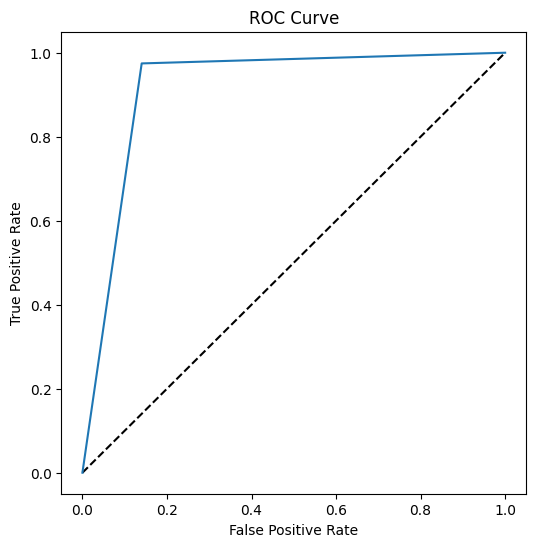

In [94]:
knn = KNeighborsClassifier(n_neighbors = 9, metric='euclidean')
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

In [81]:
pipe = make_pipeline(StandardScaler(), knn)
knn_results = cross_validate(pipe, transformed_X, transformed_y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
kfold_metrics(knn_results)

Accuracy: 0.9167
Precision: 0.8657
Recall: 0.9866
F1-score: 0.92
ROC AUC score: 0.9614


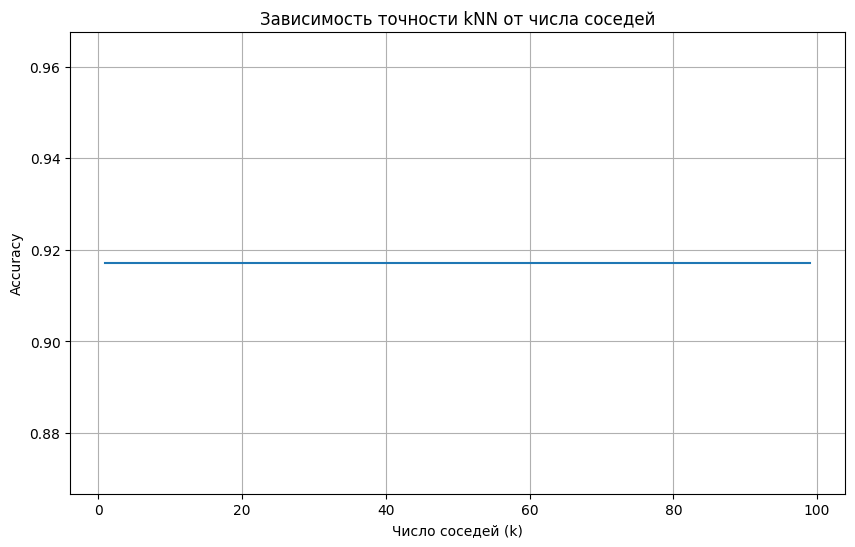

In [91]:
k_variants = [1, 5, 9, 15, 19, 25, 29, 35, 39, 99]
accuracies = []

for k in k_variants:
    knn = KNeighborsClassifier(n_neighbors = 9, metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(round(accuracy_score(y_test, y_pred), 4))

plt.figure(figsize=(10, 6))
plt.plot(k_variants, accuracies)
plt.xlabel('Число соседей (k)')
plt.ylabel('Accuracy')
plt.title('Зависимость точности kNN от числа соседей')
plt.grid(True)
plt.show()

In [15]:
parameters = {'n_neighbors': np.arange(1, np.sqrt(len(y_train)), 2, dtype=int)}

In [16]:
knn = GridSearchCV(KNeighborsClassifier(), parameters).fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_metrics(y_test, y_pred)
knn.best_params_

Accuracy: 0.9177
Precision: 0.8672
Recall: 0.9863
F1-score: 0.92
ROC AUC score: 0.9177
Confusion matrix: 
 [[12732  2265]
 [  205 14792]]


{'n_neighbors': np.int64(21)}

In [17]:
knn = RandomizedSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print_metrics(y_test, y_pred)
knn.best_params_

Accuracy: 0.9173
Precision: 0.8667
Recall: 0.9863
F1-score: 0.92
ROC AUC score: 0.9173
Confusion matrix: 
 [[12722  2275]
 [  206 14791]]


{'n_neighbors': np.int64(23)}

In [27]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=UserWarning)

In [45]:
def objective(trial):
    k = trial.suggest_int('n_neighbors', 1, np.sqrt(len(y_train)), step=2)
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

In [46]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_k = study.best_params['n_neighbors']
knn_best_model = KNeighborsClassifier(n_neighbors=best_k)
knn_best_model.fit(X_train_scaled, y_train)

y_pred = knn_best_model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
best_k

Accuracy: 0.9178
Precision: 0.868
Recall: 0.9855
F1-score: 0.92
ROC AUC score: 0.9178
Confusion matrix: 
 [[12750  2247]
 [  218 14779]]


19

<font size = 6>
    <b>Logistic Regression</b>
</font>

Accuracy: 0.9012
Precision: 0.8572
Recall: 0.9628
F1-score: 0.91
ROC AUC score: 0.9012
Confusion matrix: 
 [[12592  2405]
 [  558 14439]]
Log_loss: 3.560623624456696


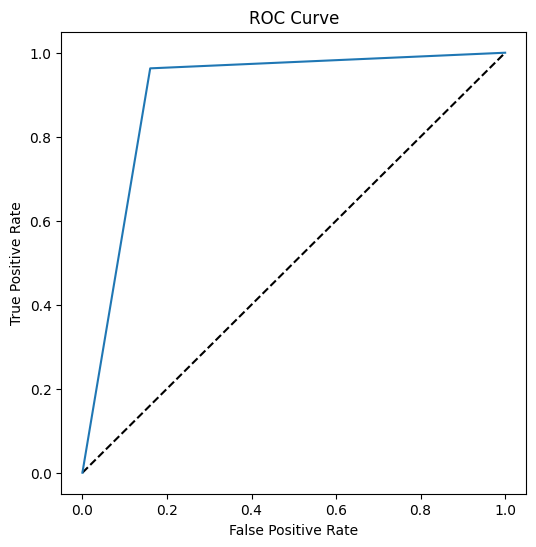

In [31]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print_metrics(y_test, y_pred)
print('Log_loss:', log_loss(y_test, y_pred))
plot_roc_curve(y_test, y_pred)

In [82]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
lr_results = cross_validate(pipe, transformed_X, transformed_y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
kfold_metrics(lr_results)

Accuracy: 0.901
Precision: 0.8574
Recall: 0.962
F1-score: 0.91
ROC AUC score: 0.9448


In [48]:
parameters = {'C': np.arange(0.1, 1.1, 0.1)}

In [49]:
lr = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print_metrics(y_test, y_pred)
print('Log_loss:', log_loss(y_test, y_pred))
lr.best_params_

Accuracy: 0.9013
Precision: 0.8566
Recall: 0.9641
F1-score: 0.91
ROC AUC score: 0.9013
Confusion matrix: 
 [[12577  2420]
 [  539 14458]]
Log_loss: 3.5558168426484515


{'C': np.float64(0.1)}

In [50]:
lr = RandomizedSearchCV(LogisticRegression(), parameters, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
print_metrics(y_test, y_pred)
print('Log_loss:', log_loss(y_test, y_pred))
lr.best_params_

Accuracy: 0.9013
Precision: 0.8566
Recall: 0.9641
F1-score: 0.91
ROC AUC score: 0.9013
Confusion matrix: 
 [[12577  2420]
 [  539 14458]]
Log_loss: 3.5558168426484515


{'C': np.float64(0.1)}

In [51]:
def objective(trial):
    c = trial.suggest_float('C', 0.1, 1, step=0.1)
    model = LogisticRegression(C = c)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return log_loss(y_test, y_pred)

In [52]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_c = study.best_params['C']
lr_best_model = LogisticRegression(C = best_c)
lr_best_model.fit(X_train_scaled, y_train)

y_pred = lr_best_model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
print('Log_loss:', log_loss(y_test, y_pred))
best_c

Accuracy: 0.9013
Precision: 0.8566
Recall: 0.9641
F1-score: 0.91
ROC AUC score: 0.9013
Confusion matrix: 
 [[12577  2420]
 [  539 14458]]
Log_loss: 3.5558168426484515


0.1

<font size = 6>
    <b>Naive Bayes</b>
</font>

Accuracy: 0.9059
Precision: 0.8529
Recall: 0.9811
F1-score: 0.91
ROC AUC score: 0.9059
Confusion matrix: 
 [[12459  2538]
 [  284 14713]]


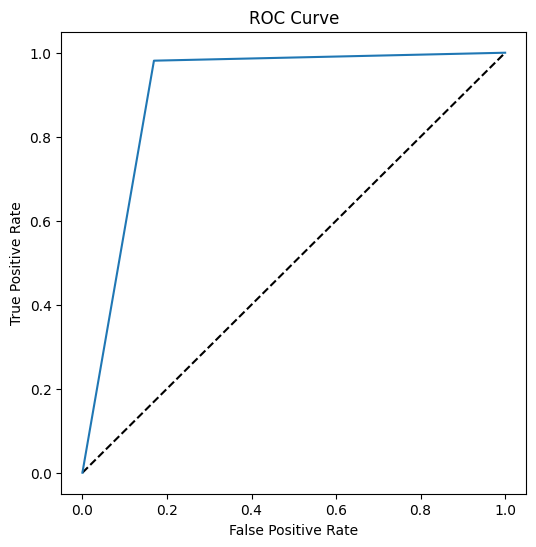

In [37]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
y_pred = gnb.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

In [83]:
pipe = make_pipeline(StandardScaler(), GaussianNB())
gnb_results = cross_validate(pipe, transformed_X, transformed_y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
kfold_metrics(gnb_results)

Accuracy: 0.9063
Precision: 0.8528
Recall: 0.9819
F1-score: 0.91
ROC AUC score: 0.9121


<font size = 6>
    <b>SVM</b>
</font>

Accuracy: 0.9144
Precision: 0.8582
Recall: 0.9928
F1-score: 0.92
ROC AUC score: 0.9144
Confusion matrix: 
 [[12537  2460]
 [  108 14889]]


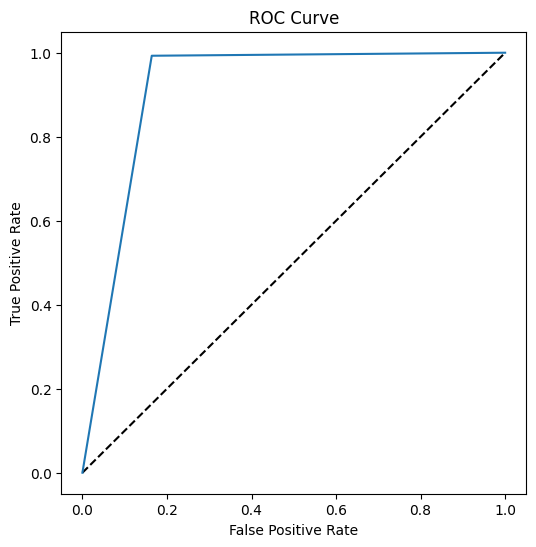

In [38]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)
print_metrics(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

In [84]:
pipe = make_pipeline(StandardScaler(), SVC())
svc_results = cross_validate(pipe, transformed_X, transformed_y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
kfold_metrics(svc_results)

Accuracy: 0.9146
Precision: 0.8586
Recall: 0.9927
F1-score: 0.92
ROC AUC score: 0.9516


In [ ]:
parameters = {'C': np.arange(0.1, 1.1, 0.1),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [67]:
svc = GridSearchCV(SVC(), parameters, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)
print_metrics(y_test, y_pred)
svc.best_params_

Accuracy: 0.9144
Precision: 0.8582
Recall: 0.9928
F1-score: 0.92
ROC AUC score: 0.9144
Confusion matrix: 
 [[12537  2460]
 [  108 14889]]


{'C': np.float64(1.0), 'kernel': 'rbf'}

In [54]:
svc = RandomizedSearchCV(SVC(), parameters, n_jobs=-1).fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)
print_metrics(y_test, y_pred)
svc.best_params_

Accuracy: 0.9142
Precision: 0.8579
Recall: 0.9928
F1-score: 0.92
ROC AUC score: 0.9142
Confusion matrix: 
 [[12531  2466]
 [  108 14889]]


{'kernel': 'rbf', 'C': np.float64(0.5)}

In [57]:
def objective(trial):
    c = trial.suggest_float('C', 0.1, 1, step=0.1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    model = SVC(C=c, kernel=kernel)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
svc_best_model = SVC(C=best_params['C'], kernel=best_params['kernel'])
svc_best_model.fit(X_train_scaled, y_train)

y_pred = svc_best_model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
best_params

Accuracy: 0.8193
Precision: 0.8178
Recall: 0.8218
F1-score: 0.82
ROC AUC score: 0.8193
Confusion matrix: 
 [[12251  2746]
 [ 2673 12324]]


{'C': 0.8, 'kernel': 'sigmoid'}

In [64]:
new_study = optuna.create_study(direction='maximize')
for trial in study.trials:
    new_study.add_trial(trial)
best_params = new_study.best_params
svc_best_model = SVC(C=best_params['C'], kernel=best_params['kernel'])
svc_best_model.fit(X_train_scaled, y_train)

y_pred = svc_best_model.predict(X_test_scaled)
print_metrics(y_test, y_pred)
best_params

Accuracy: 0.9144
Precision: 0.8582
Recall: 0.9928
F1-score: 0.92
ROC AUC score: 0.9144
Confusion matrix: 
 [[12537  2460]
 [  108 14889]]


{'C': 1.0, 'kernel': 'rbf'}

In [71]:
sklearn_knn = KNeighborsClassifier(n_neighbors = 9, metric='euclidean')
sklearn_knn.fit(X_train_scaled, y_train)

sklearn_train_pred = knn.predict(X_train_scaled)
sklearn_test_pred = knn.predict(X_test_scaled)

In [73]:
from KNN import KNN

my_knn = KNN(k = 9)
my_knn.fit(X_train_scaled, y_train)
my_train_pred = my_knn.predict(X_train_scaled)
my_test_pred = my_knn.predict(X_test_scaled)

In [76]:
predictions = [sklearn_train_pred, my_train_pred]
estimator_names = ['kNN из sklearn', 'Программный kNN']

table_train = pd.DataFrame()

table_train.loc[estimator_names[0], 'F1'] = round(f1_score(y_train, predictions[0]), 2)
table_train.loc[estimator_names[1], 'F1'] = round(f1_score(y_train, predictions[1]), 2)
table_train.loc[estimator_names[0], 'accuracy'] = round(accuracy_score(y_train, predictions[0]), 4)
table_train.loc[estimator_names[1], 'accuracy'] = round(accuracy_score(y_train, predictions[1]), 4)
table_train.loc[estimator_names[0], 'precision'] = round(precision_score(y_train, predictions[0]), 4)
table_train.loc[estimator_names[1], 'precision'] = round(precision_score(y_train, predictions[1]), 4)
table_train.loc[estimator_names[0], 'recall'] = round(recall_score(y_train, predictions[0]), 4)
table_train.loc[estimator_names[1], 'recall'] = round(recall_score(y_train, predictions[1]), 4)

table_train

,F1,accuracy,precision,recall
kNN из sklearn,0.93,0.9199,0.8699,0.9876
Программный kNN,0.93,0.9264,0.8839,0.9817


In [77]:
predictions = [sklearn_test_pred, my_test_pred]

table_test = pd.DataFrame()

table_test.loc[estimator_names[0], 'F1'] = round(f1_score(y_test, predictions[0]), 2)
table_test.loc[estimator_names[1], 'F1'] = round(f1_score(y_test, predictions[1]), 2)
table_test.loc[estimator_names[0], 'accuracy'] = round(accuracy_score(y_test, predictions[0]), 4)
table_test.loc[estimator_names[1], 'accuracy'] = round(accuracy_score(y_test, predictions[1]), 4)
table_test.loc[estimator_names[0], 'precision'] = round(precision_score(y_test, predictions[0]), 4)
table_test.loc[estimator_names[1], 'precision'] = round(precision_score(y_test, predictions[1]), 4)
table_test.loc[estimator_names[0], 'recall'] = round(recall_score(y_test, predictions[0]), 4)
table_test.loc[estimator_names[1], 'recall'] = round(recall_score(y_test, predictions[1]), 4)

table_test

,F1,accuracy,precision,recall
kNN из sklearn,0.92,0.9173,0.8667,0.9863
Программный kNN,0.92,0.9172,0.8742,0.9745


In [78]:
import classification_metrics

estimators = [knn_best_model, lr_best_model, gnb, svc_best_model]
estimator_names = ['kNN', 'Logistic Regression', 'Naive Bayes', 'SVC']

table_train = pd.DataFrame()
for i in range(len(estimators)):
    y_pred = estimators[i].predict(X_train_scaled)
    table_train.loc[estimator_names[i], 'sklearn_F1'] = round(f1_score(y_train, y_pred), 2)
    table_train.loc[estimator_names[i], 'custom_F1'] = round(classification_metrics.f1(y_train, y_pred), 2)
    table_train.loc[estimator_names[i], 'sklearn_accuracy'] = round(accuracy_score(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_accuracy'] = round(classification_metrics.accuracy(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'sklearn_precision'] = round(precision_score(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_precision'] = round(classification_metrics.precision(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'sklearn_recall'] = round(recall_score(y_train, y_pred), 4)
    table_train.loc[estimator_names[i], 'custom_recall'] = round(classification_metrics.recall(y_train, y_pred), 4)
table_train

,sklearn_F1,custom_F1,sklearn_accuracy,custom_accuracy,sklearn_precision,custom_precision,sklearn_recall,custom_recall
kNN,0.93,0.93,0.9206,0.9206,0.8718,0.8718,0.9861,0.9861
Logistic Regression,0.91,0.91,0.9012,0.9012,0.8569,0.8569,0.9632,0.9632
Naive Bayes,0.91,0.91,0.9065,0.9065,0.8528,0.8528,0.9825,0.9825
SVC,0.92,0.92,0.9146,0.9146,0.8586,0.8586,0.9927,0.9927


In [79]:
table_test = pd.DataFrame()
for i in range(len(estimators)):
    y_pred = estimators[i].predict(X_test_scaled)
    table_test.loc[estimator_names[i], 'sklearn_F1'] = round(f1_score(y_test, y_pred), 2)
    table_test.loc[estimator_names[i], 'custom_F1'] = round(classification_metrics.f1(y_test, y_pred), 2)
    table_test.loc[estimator_names[i], 'sklearn_accuracy'] = round(accuracy_score(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_accuracy'] = round(classification_metrics.accuracy(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'sklearn_precision'] = round(precision_score(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_precision'] = round(classification_metrics.precision(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'sklearn_recall'] = round(recall_score(y_test, y_pred), 4)
    table_test.loc[estimator_names[i], 'custom_recall'] = round(classification_metrics.recall(y_test, y_pred), 4)
table_test

,sklearn_F1,custom_F1,sklearn_accuracy,custom_accuracy,sklearn_precision,custom_precision,sklearn_recall,custom_recall
kNN,0.92,0.92,0.9178,0.9178,0.8680,0.8680,0.9855,0.9855
Logistic Regression,0.91,0.91,0.9013,0.9013,0.8566,0.8566,0.9641,0.9641
Naive Bayes,0.91,0.91,0.9059,0.9059,0.8529,0.8529,0.9811,0.9811
SVC,0.92,0.92,0.9144,0.9144,0.8582,0.8582,0.9928,0.9928


In [86]:
kfold_results = [knn_results, lr_results, gnb_results, svc_results]
estimators = [KNeighborsClassifier(n_neighbors=9, metric='euclidean'), LogisticRegression(), GaussianNB(), SVC()]
estimator_names = ['kNN', 'Logistic Regression', 'Naive Bayes', 'SVC']

table = pd.DataFrame()
for i in range(len(estimators)):
    model = estimators[i].fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    table.loc[estimator_names[i], 'holdout_F1'] = round(f1_score(y_test, y_pred), 2)
    table.loc[estimator_names[i], 'kfold_F1'] = round(np.mean(kfold_results[i]['test_f1']), 2)
    table.loc[estimator_names[i], 'holdout_accuracy'] = round(accuracy_score(y_test, y_pred), 4)
    table.loc[estimator_names[i], 'kfold_accuracy'] = round(np.mean(kfold_results[i]['test_accuracy']), 4)
    table.loc[estimator_names[i], 'holdout_precision'] = round(precision_score(y_test, y_pred), 4)
    table.loc[estimator_names[i], 'kfold_precision'] = round(np.mean(kfold_results[i]['test_precision']), 4)
    table.loc[estimator_names[i], 'holdout_recall'] = round(recall_score(y_test, y_pred), 4)
    table.loc[estimator_names[i], 'kfold_recall'] = round(np.mean(kfold_results[i]['test_recall']), 4)
table

,holdout_F1,kfold_F1,holdout_accuracy,kfold_accuracy,holdout_precision,kfold_precision,holdout_recall,kfold_recall
kNN,0.92,0.92,0.9172,0.9167,0.8742,0.8657,0.9745,0.9866
Logistic Regression,0.91,0.91,0.9012,0.9010,0.8572,0.8574,0.9628,0.9620
Naive Bayes,0.91,0.91,0.9059,0.9063,0.8529,0.8528,0.9811,0.9819
SVC,0.92,0.92,0.9144,0.9146,0.8582,0.8586,0.9928,0.9927


In [14]:
import pickle

model = KNeighborsClassifier(n_neighbors=9, metric='euclidean')
model.fit(X_train_scaled, y_train)

with open('../models/knn.pkl', 'wb') as f:
    pickle.dump(model, f)

<font size = 6>
    <b>Вывод  </b>  
</font>

<font size = 4>

По результатам сравнения метрик качества различных моделей лучшими метриками являются kNN и SVC, хотя остальные модели почти не отстают.

<b>Метрика F1:</b>  
* kNN: 0.93 на тренировочных данных и 0.92 на тестовых
* Logistic Regression: 0.91 на тренировочных данных и 0.91 на тестовых
* Naive Bayes: 0.91 на тренировочных данных и 0.91 на тестовых
* SVC: 0.92 на тренировочных данных и 0.92 на тестовых

<b>Метрика Accuracy:</b>  
* kNN: 0.9206 на тренировочных данных и 0.9178 на тестовых
* Logistic Regression: 0.9012 на тренировочных данных и 0.9013 на тестовых
* Naive Bayes: 0.9065 на тренировочных данных и 0.9059 на тестовых
* SVC: 0.9146 на тренировочных данных и 0.9144 на тестовых

<b>Метрика Precision:</b>  
* kNN: 0.8718 на тренировочных данных и 0.8680 на тестовых
* Logistic Regression: 0.8569 на тренировочных данных и 0.8566 на тестовых
* Naive Bayes: 0.8528 на тренировочных данных и 0.8529 на тестовых
* SVC: 0.8586 на тренировочных данных и 0.8582 на тестовых

<b>Метрика Recall:</b>  
* kNN: 0.9861 на тренировочных данных и 0.9855 на тестовых
* Logistic Regression: 0.9632 на тренировочных данных и 0.9641 на тестовых
* Naive Bayes: 0.9825 на тренировочных данных и 0.9811 на тестовых
* SVC: 0.9927 на тренировочных данных и 0.9928 на тестовых

Метрики качества у всех моделей близки к единице, можно заключить, что все модели работают примерно одинаково хорошо.  

Результаты метрик для тренировочных и тестовых данных примерно совпадают, что позволяет говорить, что модель не была переобучена
</font>

In [96]:
# Сохранение всех переменных
dill.dump_session('session.pkl')

In [ ]:
# Загрузка
dill.load_session('session.pkl')